<a href="https://colab.research.google.com/github/thor4/neuralnets/blob/master/projects/1-CNN/step1-train_vanilla_CNN_v2-cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create Vanilla CNN to Classify CIFAR10 Images
### Adapted from [Convolutional Neural Network (CNN) Tensorflow tutorial](https://www.tensorflow.org/tutorials/images/cnn).
--- 
## Import libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Nov  3 14:34:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


### Load and prepare the data
The dataset is comprised of 60,000 color images in 10 classes, with 6,000 images in each class. There are 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

500 Gabors were generated for each of the 18 groups for each of the 2 classes (500 x 18 x 2 = 18,000 total images). The dataset is divided into 11,988 training images, 4,788 validation images, and 1,224 testing images. The batch size was set at 32 and image size at 160 x 160. 

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# def load_data():
#     curr_dir = os.getcwd() 
#     train_dir = os.path.join(curr_dir, 'train_range')
#     validation_dir = os.path.join(curr_dir, 'validation_range')
#     test_dir = os.path.join(curr_dir, 'test_range')
#     BATCH_SIZE = 32 
#     IMG_SIZE = (160, 160)
#     train_dataset = image_dataset_from_directory(train_dir,
#                                              shuffle=True,
#                                              batch_size=BATCH_SIZE,
#                                              image_size=IMG_SIZE,
#                                              color_mode='grayscale') 
#     validation_dataset = image_dataset_from_directory(validation_dir,
#                                                   shuffle=True,
#                                                   batch_size=BATCH_SIZE,
#                                                   image_size=IMG_SIZE,
#                                                   color_mode='grayscale') 
#     test_dataset = image_dataset_from_directory(test_dir,
#                                                   shuffle=True,
#                                                   batch_size=BATCH_SIZE,
#                                                   image_size=IMG_SIZE,
#                                                   color_mode='grayscale') 
#     class_names = train_dataset.class_names #assign clockwise (clock) & counterclockwise (cclock) classes
#     return BATCH_SIZE,IMG_SIZE,train_dataset,validation_dataset,test_dataset,class_names

# BATCH_SIZE, IMG_SIZE, train_dataset, validation_dataset, test_dataset, class_names = load_data()

170508288/170498071 [==============================] - 3s 0us/step


In [5]:
print(train_images.shape)
print(train_labels.shape)

(50000, 32, 32, 3)
(50000, 1)


### Standardize the data
The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general we should seek to make our input values small. We will standardize values to be in the `[0, 1]` range by dividing by 255.

In [4]:
train_images, test_images = train_images / 255.0, test_images / 255.0

### Verify the data
To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:

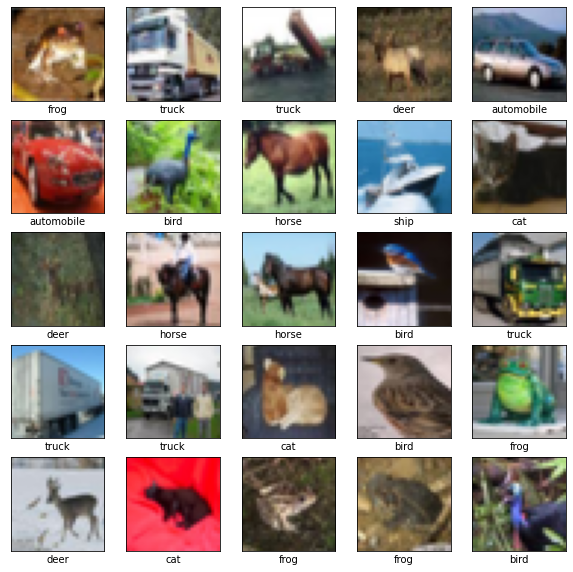

In [5]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

Resize the first 25 images to match the size the vanilla model expects (160, 160) and plot to confirm images are the same.

In [6]:
train_images_big = tf.image.resize(train_images[0:26], (160,160))
train_images_big.shape

TensorShape([26, 160, 160, 3])

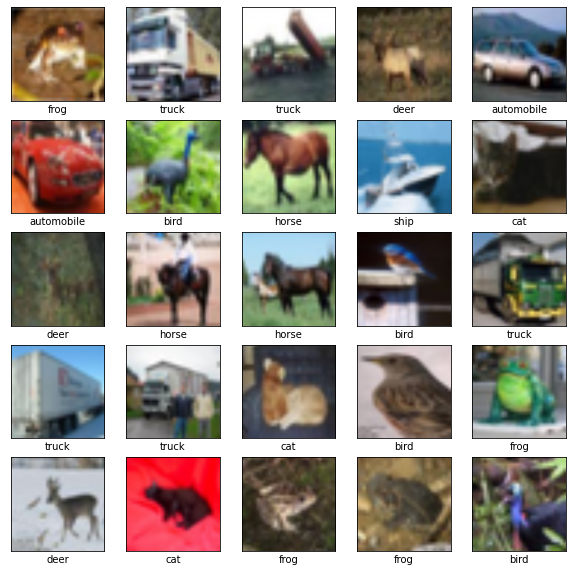

In [7]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_big[i])
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [8]:
print(f"confirming [0,1] normalization:",np.min(train_images_big[1]),np.max(train_images_big[1]))

confirming [0,1] normalization: 0.019607844 0.99607843


Now, resize all training and testing images and confirm shape. Must restart environment and skip to this step after loading data, prior to normalizing.

In [6]:
# train_images_big = tf.image.resize(train_images[0:10000], (160,160))
# train_images_big = tf.image.resize(train_images[10000:20000], (160,160))
# train_images_big = tf.image.resize(train_images[20000:30000], (160,160))
# train_images_big = tf.image.resize(train_images[30000:40000], (160,160))
# train_images_big = tf.image.resize(train_images[40000:50000], (160,160))
train_images_big = tf.image.resize(train_images, (160,160))
test_images_big = tf.image.resize(test_images, (160,160))
print(train_images_big.shape)
print(test_images_big.shape)

(50000, 160, 160, 3)
(10000, 160, 160, 3)



### Standardize the data
The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general we should seek to make our input values small. We will standardize values to be in the `[0, 1]` range by using the `tf.keras.layers.experimental.preprocessing.Rescaling` layer.

### Create the model

The first 3 lines of code below instantiate the Sequential model definition, declare the input shape of the images then apply the normalization layer.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. color_channels refers to (R,G,B). We will configure the CNN to process inputs of shape (160, 160, 3), which is the format of our CIFAR10 images and later, Gabors. We can do this by passing the argument `input_shape` to the first layer titled `InputLayer`.

The next 5 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

To complete the model, we will feed the last output tensor from the convolutional base (of shape (36, 36, 320)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, we will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. Our dataset has 2 output classes, so we use a final Dense layer with a single logit output prediction.

In [22]:
model = models.Sequential()
model.add(layers.InputLayer(input_shape=(160,160,3)))
model.add(layers.experimental.preprocessing.Rescaling(1./255)) #normalization layer
model.add(layers.Conv2D(160, (3, 3), activation='relu', input_shape=(160, 160, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.BatchNormalization())
model.add(layers.Conv2D(80, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(20, (3, 3), activation='relu'))
model.add(layers.Flatten()) #flatten from 3d output to 1d
model.add(layers.Dense(80, activation='relu'))
model.add(layers.Dense(10))

Let's display the architecture of the model so far:

In [23]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 160, 160, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 158, 158, 160)     4480      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 79, 79, 160)       0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 39, 39, 160)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 37, 37, 80)        115280    
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 18, 18, 80)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 25920)            

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as we go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 160 or 320). Typically, as the width and height shrink, we can afford (computationally) to add more output channels in each Conv2D layer.

Finally, we see that (18, 18, 30) outputs were flattened into vectors of shape (9720) before going through two Dense layers.

### Compile and train the model

We will define the learning rate and use the BinaryCrossEntropy loss since the model provides a single linear output

In [24]:
base_learning_rate = 0.0001 #define the learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

history = model.fit(train_images_big, 
                    train_labels, 
                    epochs=10, 
                    validation_data=(test_images_big, test_labels))

Epoch 1/10
1563/1563 [==============================] - 46s 29ms/step - loss: 1.6999 - accuracy: 0.3981 - val_loss: 1.4422 - val_accuracy: 0.4827
Epoch 2/10
1563/1563 [==============================] - 44s 28ms/step - loss: 1.3531 - accuracy: 0.5212 - val_loss: 1.2964 - val_accuracy: 0.5398
Epoch 3/10
1563/1563 [==============================] - 45s 29ms/step - loss: 1.2368 - accuracy: 0.5655 - val_loss: 1.2614 - val_accuracy: 0.5524
Epoch 4/10
1563/1563 [==============================] - 44s 28ms/step - loss: 1.1652 - accuracy: 0.5919 - val_loss: 1.1932 - val_accuracy: 0.5851
Epoch 5/10
1563/1563 [==============================] - 45s 29ms/step - loss: 1.1127 - accuracy: 0.6119 - val_loss: 1.1554 - val_accuracy: 0.5951
Epoch 6/10
1563/1563 [==============================] - 44s 28ms/step - loss: 1.0675 - accuracy: 0.6295 - val_loss: 1.1398 - val_accuracy: 0.5982
Epoch 7/10
1563/1563 [==============================] - 44s 28ms/step - loss: 1.0250 - accuracy: 0.6429 - val_loss: 1.1359 -

###STOPPED HERE. SAVE MODEL AND TRY TRANSFER LEARNING.

### Evaluate the model
Let's make a plot to visualize how the training and validation accuracy improves with each epoch. We will also evaluate the model against the test dataset.

39/39 - 1s - loss: 0.4477 - accuracy: 0.8268


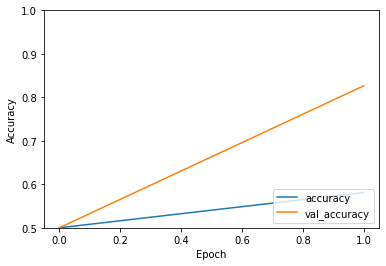

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_dataset, verbose=2)

Nicely done! The model achieved a 82.64% accuracy on the validation set and a 82.68% accuracy on the test set after 2 epochs. This is close to the human-level accuracy observed during the behavioral experiment. Now let's save our vanilla CNN model.

In [ ]:
model.save('18kim_range_vanilla_v2')

INFO:tensorflow:Assets written to: 18kim_range_vanilla_v2/assets


In [ ]:
os.getcwd()

'/content/model2_training'

In [ ]:
! zip -r vanilla_model.zip 18kim_range_vanilla_v2/

  adding: 18kim_range_vanilla_v2/ (stored 0%)
  adding: 18kim_range_vanilla_v2/assets/ (stored 0%)
  adding: 18kim_range_vanilla_v2/variables/ (stored 0%)
  adding: 18kim_range_vanilla_v2/variables/variables.index (deflated 64%)
  adding: 18kim_range_vanilla_v2/variables/variables.data-00000-of-00001 (deflated 26%)
  adding: 18kim_range_vanilla_v2/keras_metadata.pb (deflated 90%)
  adding: 18kim_range_vanilla_v2/saved_model.pb (deflated 89%)


In [ ]:
/content/model2_training/18kim_range_vanilla_v2/